# Preprocessing Images for OCR

1. Inverted Images
2. Rescaling
3. Binarization
4. Noise Removal
5. Dilation and Erosion
6. Rotation / Deskewing
7. Removing Borders
8. Missing Borders
9. Transparency / Alpha Channel

## 00: Opening an Image

In [535]:
import cv2
from matplotlib import pyplot as plt
image_file="passport/1.jpg"
img = cv2.imread(image_file)
if img is None:
    print("Error: Image not loaded correctly!")
else:
    print("Image loaded successfully!")

Image loaded successfully!


In [536]:
#https://stackoverflow.com/questions/28816046/
#displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im_path):
    dpi = 100
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

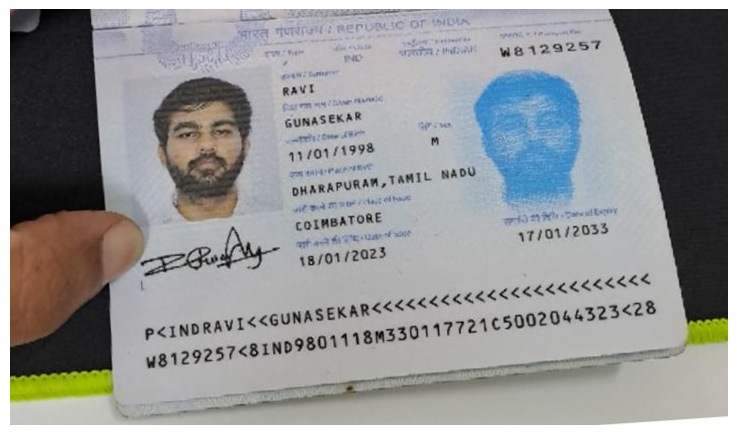

In [537]:
display("passport/1.jpg")

## 01: Inverted Images

In [538]:
inverted_image=cv2.bitwise_not(img)
cv2.imwrite("temp/inverted.jpg",inverted_image)

True

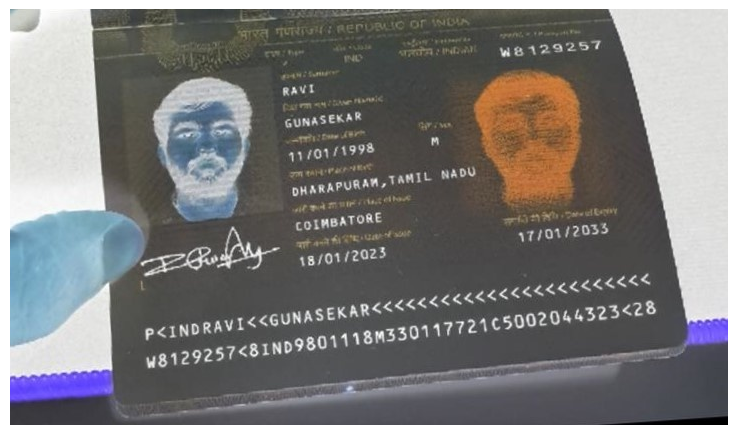

In [539]:
display("temp/inverted.jpg")

## 02: Rescaling

## 03: Binarization

In [540]:
def greyscale(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

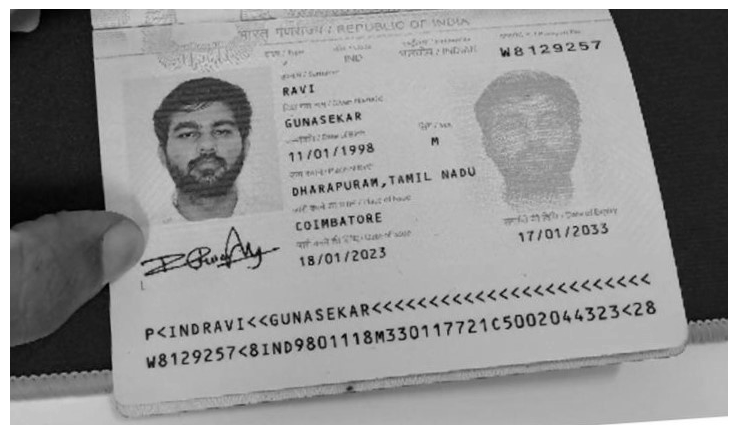

In [541]:
gray_image=greyscale(img)
cv2.imwrite("temp/grey.jpg",gray_image)
display("temp/grey.jpg")

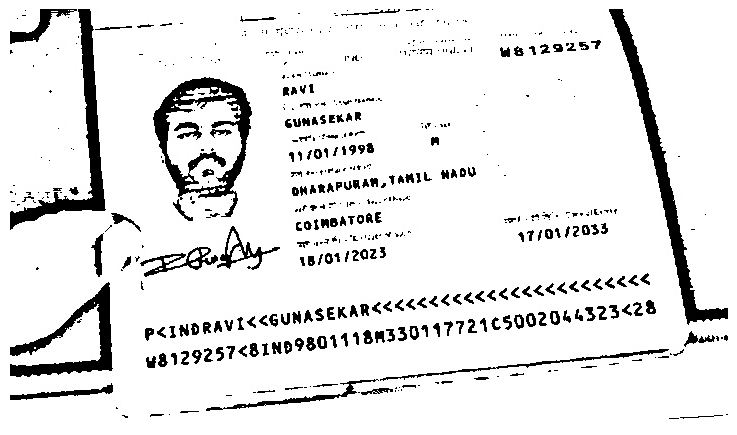

In [542]:
#im_bw=cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 10)
import numpy as np
from skimage.filters import threshold_sauvola
window_size = 25  # Size of the local region (adjust as needed)
sauvola_thresh =threshold_sauvola(gray_image, window_size=window_size)

# Convert to binary image (black & white)
binary_image = (gray_image > sauvola_thresh).astype(np.uint8) * 255
cv2.imwrite("temp/bw_image.jpg",binary_image)
display("temp/bw_image.jpg")

## 04: Noise Removal


In [543]:
def noise_removal(image):
    import numpy as np
    kernel=np.ones((1,1),np.uint8)
    image=cv2.dilate(image,kernel,iterations=1)
    kernel=np.ones((1,1),np.uint8)
    image=cv2.erode(image,kernel,iterations=1)
    image=cv2.morphologyEx(image,cv2.MORPH_CLOSE,kernel)
    image=cv2.medianBlur(image,3)
    return (image)

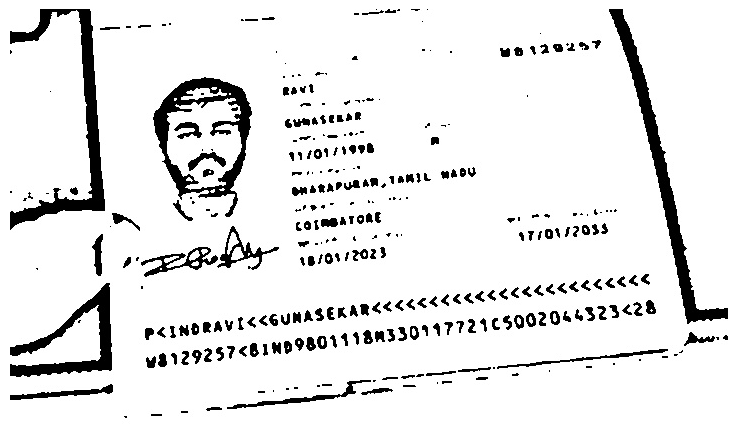

In [544]:
no_noise=noise_removal(binary_image)
cv2.imwrite("temp/no_noise.jpg",no_noise)
display("temp/no_noise.jpg")

## Dilation and Erosion

In [545]:
def thick_font(image):
    import numpy as np
    image=cv2.bitwise_not(image)
    kernel=np.ones((2,2),np.uint8)
    image= cv2.erode(image,kernel,iterations=1)
    image=cv2.bitwise_not(image)
    return(image)

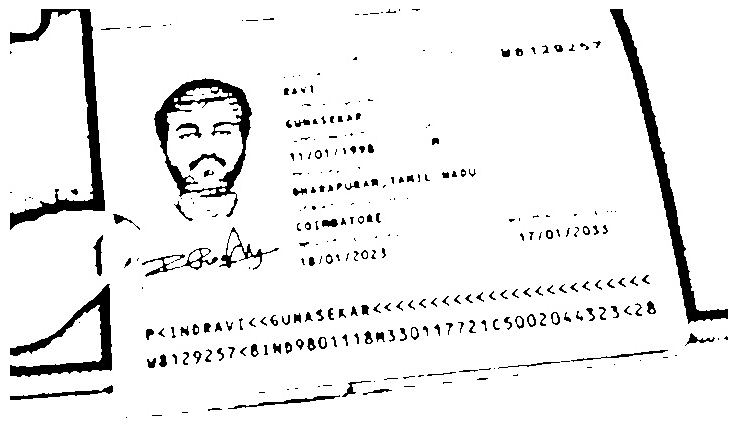

In [546]:
eroded_image=thick_font(no_noise)
cv2.imwrite("temp/eroded_image.jpg",eroded_image)
display("temp/eroded_image.jpg")

In [547]:
def thin_font(image):
    import numpy as np
    image=cv2.bitwise_not(image)
    kernel=np.ones((2,2),np.uint8)
    image=cv2.dilate(image,kernel,iterations=1)
    image=cv2.bitwise_not(image)
    return(image)

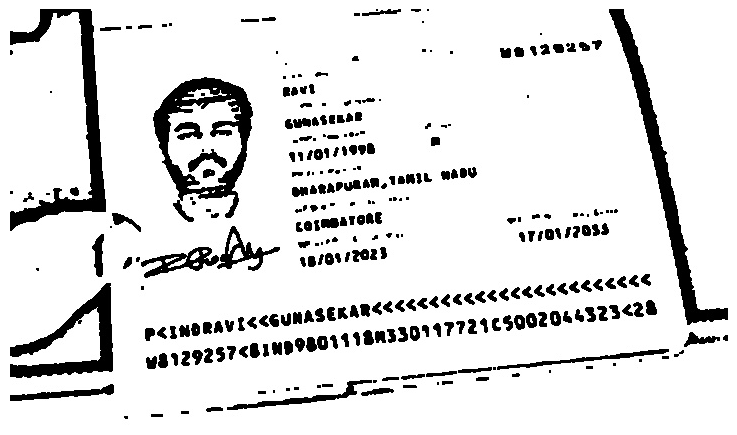

In [548]:
dilated_image=thin_font(no_noise)
cv2.imwrite("temp/dilated.jpg",dilated_image)
display("temp/dilated.jpg")

## 06: Rotation / Deskewing

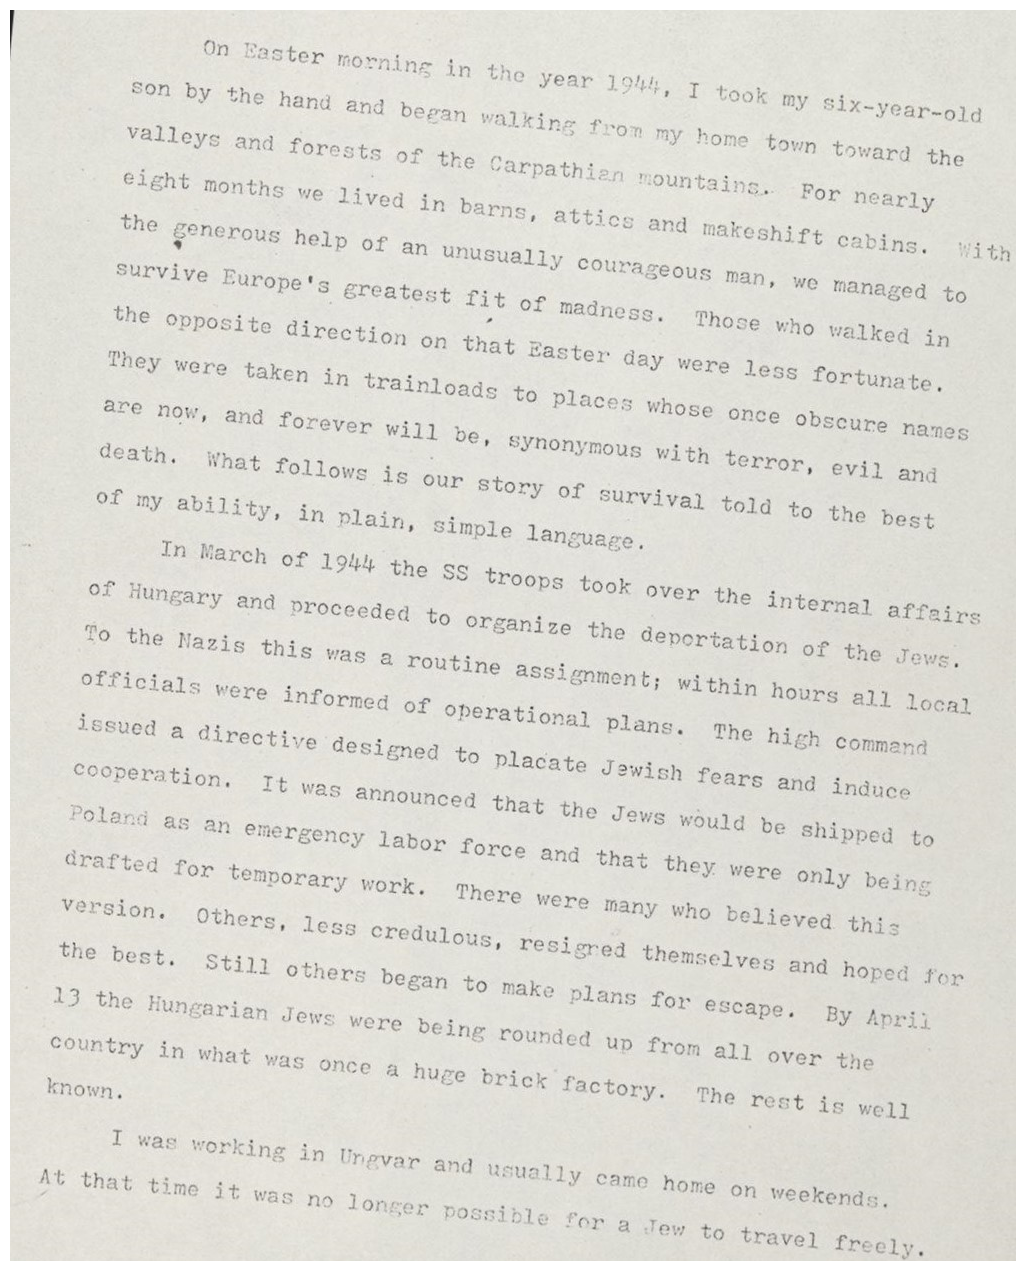

In [549]:
new=cv2.imread("data/page_01_rotated.JPG")
display("data/page_01_rotated.JPG")

In [550]:
#https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
import numpy as np

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [551]:
def deskew(cvImage):
    angle=getSkewAngle(cvImage)
    return rotateImage(cvImage,-1 * angle)

28


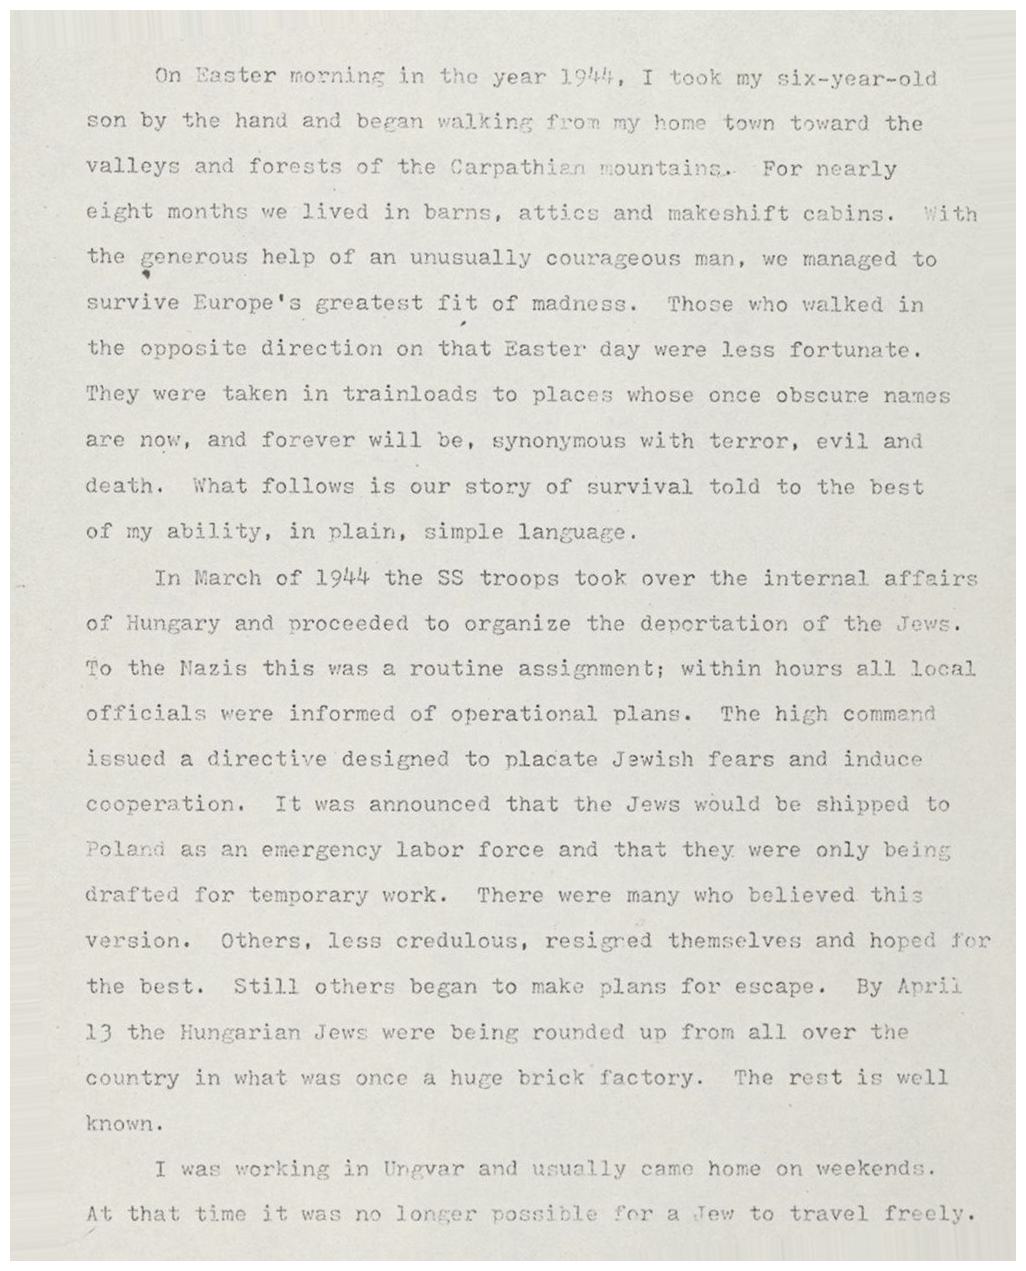

In [552]:
fixed = deskew(new)
cv2.imwrite("temp/rotated_fixed.jpg", fixed)
display("temp/rotated_fixed.jpg")

## 07.removing borders

In [553]:
def remove_borders(image):
    contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

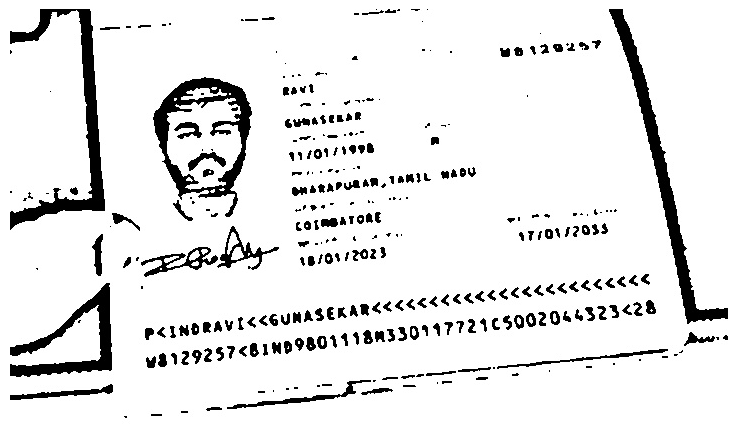

In [554]:
no_borders = remove_borders(no_noise)
cv2.imwrite("temp/no_borders.jpg", no_borders)
display('temp/no_borders.jpg')

## 08. Adding borders

In [555]:
color = [255, 255, 255]
top, bottom, left, right = [150]*4

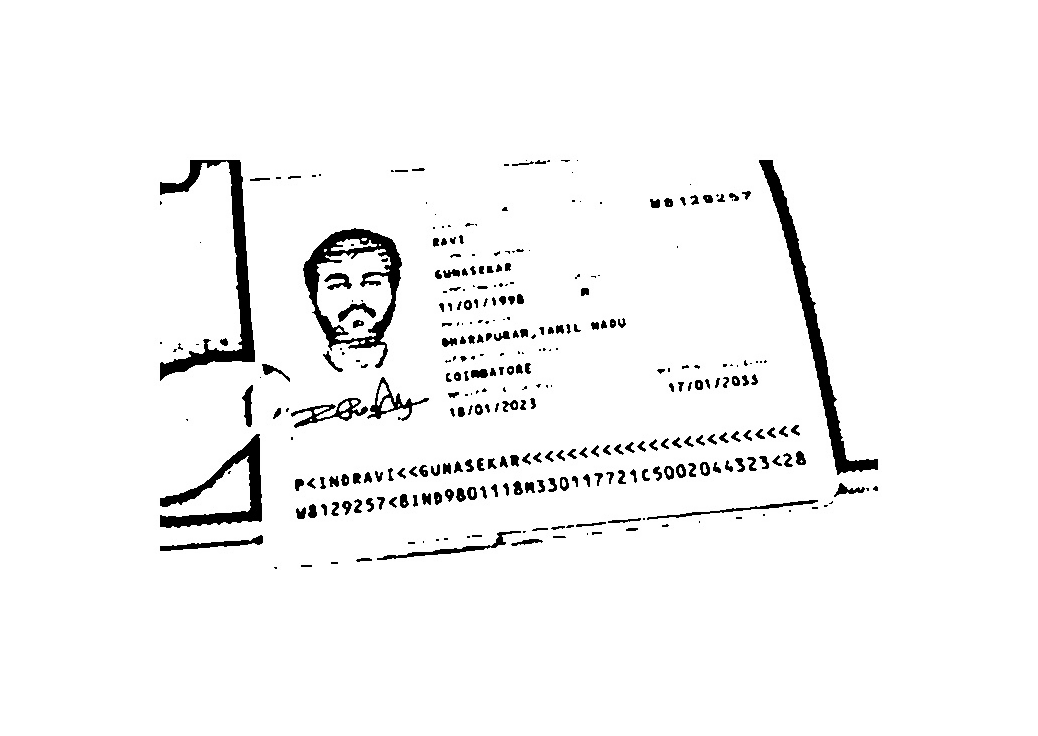

In [556]:
image_with_border=cv2.copyMakeBorder(no_noise,top,bottom,left,right,cv2.BORDER_CONSTANT,value=color)
cv2.imwrite("temp/border_img.jpg",image_with_border)
display("temp/border_img.jpg")